# Deep Calibration: learning local stochastic volatility from price data

Instead of learning maps from parameters to prices as we have seen in a first approach, or learning directly the solution of the inverse problem, see Andres Hernandez's work [Model calibration with neural networks](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2812140), or work of Cuchiero et al., we can in case of local stochastic volatility models choose a third approach (this is joint work with Christa Cuchiero and Wahid Khosrawi-Sardroudi):

Consider the model
$$
dS_t = \alpha_t \sigma(t,S_t) dW_t
$$
with initial value $ S_0 $. At first we calibrate the pure SV-model with $\sigma = 1$ by means of an ordinary optimization using Scipy. Subsequently the the local volatility function $ \sigma $ from derivatives's prices is inferred in the following machine learning fashion: try to find a function $ \sigma $, given as neural network, and hedges $ H^{(K,T)} $ such that
$$
\sum_{(K,T)} E\big[{((S_T-K)_+ - C_{\text{market}}(K,T) - (H^{(K,T)}\bullet S)_t)}^2\big] \rightarrow \text{min!}
$$
Notice that the sum is running over a finite set of price data points. The problem can possibly solve the calibration problem but one has to learn the local volatility function and the hedges simultanously.

Let us see in the sequel if this can work out. We shall use notation which reminds the above formulation.

In [2]:
import time
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
#import matplotlib.pyplot as plt
#import scipy
#from scipy.stats import norm
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
#from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Conv2D, Concatenate, Dropout, Subtract, Flatten, MaxPooling2D, Multiply, Lambda, Add, dot
from tensorflow.keras.backend import constant
from tensorflow.keras import optimizers

from tensorflow.keras.layers import Layer
#from keras.engine.topology import Layer
from tensorflow.keras import Model
from tensorflow.keras import initializers
from tensorflow.keras.constraints import max_norm
import tensorflow.keras.backend as K
#import keras.backend as K

from scipy.optimize import differential_evolution, minimize

First we create two identical models where either only hedges or local volatilities can be trained.

In [3]:
m = 10 # layer dimension
n = 2 # number of layers for local volatility
N = 20 # time discretization (should fit to maturities)
maturities = [0.5, 1.] # list of maturities in years

T = 1.0

#P = {(1.0,1.0): 0.4, (1.1,1.0):0.2, (0.9,1.0):0.5, 
#     (1.0,0.5): 0.2, (1.1,0.5):0.1, (0.9,0.5):0.3}

P= {(0.9, 0.5): 0.20042534,
    (0.9, 1.0): 0.23559685,
    (1.0, 0.5): 0.16312157,
    (1.0, 1.0): 0.20771958,
    (1.1, 0.5): 0.13154241,
    (1.1, 1.0): 0.18236567}

#P= {(0.9, 0.5): 100 * 0.20042534,
#    (0.9, 1.0): 100 * 0.23559685,
#    (1.0, 0.5): 100 * 0.16312157,
#    (1.0, 1.0): 100 * 0.20771958,
#    (1.1, 0.5): 100 * 0.13154241,
#    (1.1, 1.0): 100 * 0.18236567}

normal = tfp.distributions.Normal(loc=0., scale=1.)

def BS(x):
    price=x[0]
    vola=x[1]
    return normal.cdf((K.log(K.abs(price)/key[0])-0.5*(key[1]-j*T/N)*vola**2)/(0.00001+np.sqrt(np.abs(key[1]-j*T/N))*vola))
# increases computational time

Implement of SV-Calibration with optimization using scipy

Define functions needed for calibration and testing...

In [4]:
# def ackley(x):
#     arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
#     arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
#     return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e

# bounds = [(-5, 5), (-5, 5)]
# result = differential_evolution(ackley, bounds)
# result.x, result.fun


# brings the data into a nicer form
P_data = []
# h_data = []
for i in maturities:
    P_data.append([[key[0], P[key]] for key in P.keys() if key[1] == i])
#     h_data.append([0 for key in P.keys() if key[1] == i])

N = 20
T = 1.0
dt = T/N

# rho = tf.Variable(0.)
# nu = tf.Variable(1.)
samples = 10000
keylist = list(P.keys())



# dW1 = np.random.normal(0, np.sqrt(dt), N)
# dW2 = rho * dW1 + np.sqrt(1 - rho **2) * np.random.normal(0, np.sqrt(dt), N)
    
def sp_calibration_sv(x):
    helper = np.zeros((2,3))
    for k in range(samples):
        start = 0
        alpha = 1 # alpha_0
        S = 1 #S_0
        dW1 = np.random.normal(0, np.sqrt(dt), N)
        dW2 = x[1] * dW1 + np.sqrt(1 - x[1] **2) * np.random.normal(0, np.sqrt(dt), N)
        for i in range(len(maturities)):
            for j in range(start,int(maturities[i]*N/T)):
                alpha = alpha*(1 + x[0]*dW2[j])
                S = S*(1 + alpha*dW1[j])
            for l in range(len(P_data[i])):
                helper[i][l] = helper[i][l] + 0.5*(np.abs(S - P_data[i][l][0]) + S - P_data[i][l][0])
            start = j + 1
    return sum([ (helper[i][l]/samples - P_data[i][l][1] )**2 for i in range(len(P_data)) for l in range(len(P_data[i])) ])


# the upper function works much better and is faster...

def sp_calibration_sv2(x):
    helper = [0 for i in range(6)]
    for k in range(samples):
        start = 0
        alpha = 1 # alpha_0
        S = 1 #S_0
        dW1 = np.random.normal(0, np.sqrt(dt), N)
        dW2 = x[1] * dW1 + np.sqrt(1 - x[1]**2) * np.random.normal(0, np.sqrt(dt), N)
        for i in range(len(maturities)):
            for j in range(start,N):
                if maturities[i] >= j*T/N:
                    alpha = alpha*(1 + x[0]*dW2[j])
                    S = S*(1 + alpha*dW1[j])
                    for l in range(len(P.keys())):
                        key = keylist[l]
                        if key[1]==((j+1)*T/N):  # the option expires
                            helper[l] = helper[l] + 0.5*(np.abs(S - key[0]) + S - key[0])  # Lambda(lambda x : 0.5*(abs(x-key[0])+x-key[0]))(S)
                else:
                    start = j
                    break
    helper2 = 0
    for l in range(len(P.keys())):
        key = keylist[l]
        helper2 = helper2 + (helper[l]/samples - P[key])**2
    return helper2

def sp_test_sv(x, t_samples):
    helper = np.zeros((2,3))
    for k in range(samples):
        start = 0
        alpha = 1 # alpha_0
        S = 1 #S_0
        dW1 = np.random.normal(0, np.sqrt(dt), N)
        dW2 = x[1] * dW1 + np.sqrt(1 - x[1] **2) * np.random.normal(0, np.sqrt(dt), N)
        for i in range(len(maturities)):
            for j in range(start,int(maturities[i]*N/T)):
                alpha = alpha*(1 + x[0]*dW2[j])
                S = S*(1 + alpha*dW1[j])
            for l in range(len(P_data[i])):
                helper[i][l] = helper[i][l] + 0.5*(np.abs(S - P_data[i][l][0]) + S - P_data[i][l][0])
            start = j + 1
    return [ [helper[i][l]/samples for l in range(len(P_data[i]))] for i in range(len(P_data)) ]


# the upper function works much better and is faster...

def sp_test_sv2(x,t_samples):
    helper = np.zeros(6)
    for k in range(t_samples):
        start = 0
        alpha = 1 # alpha_0
        S = 1 #S_0
        dW1 = np.random.normal(0, np.sqrt(dt), N)
        dW2 = x[1] * dW1 + np.sqrt(1 - x[1]**2) * np.random.normal(0, np.sqrt(dt), N)
        for i in range(len(maturities)):
            for j in range(start,N):
                if maturities[i] >= j*T/N:
                    alpha = alpha*(1 + x[0]*dW2[j])
                    S = S*(1 + alpha*dW1[j])
                    for l in range(len(P.keys())):
                        key = keylist[l]
                        if key[1]==((j+1)*T/N):  # the option expires
                            helper[l] = helper[l] + 0.5*(np.abs(S-key[0]) + S - key[0])  # Lambda(lambda x : 0.5*(abs(x-key[0])+x-key[0]))(S)
                else:
                    start = j
                    break
    return helper/t_samples



Calibration through differential evolution

In [5]:
bounds = [(0.5, 1.5), (-0.5, 0.0)]

t = time.time()
result = differential_evolution(sp_calibration_sv, bounds, atol = 0.1)
print(time.time() - t)
print(result.x)
print(result.fun)
nu_res = result.x[0]
rho_res = result.x[1]

# t = time.time()
# result2 = differential_evolution(sp_calibration_sv2, bounds, atol = 0.1)
# print(time.time() - t)
# print(result2.x)
# print(result2.fun)
# nu_res2 = result2.x[0]
# rho_res2 = result2.x[1]

137.00004625320435
[ 0.92449641 -0.43701378]
0.0006066701587636885


Test:

In [6]:
print(nu_res, rho_res)
test = sp_test_sv([nu_res, rho_res],1000000)
print(test)
print(P_data)

# print(nu_res2, rho_res2)
# test2 = sp_test_sv2([nu_res2, rho_res2],10000)
# print(test2)
# print([P[key] for key in P.keys()])

0.9244964101097016 -0.43701377885829595
[[0.21821676967403977, 0.1807490860212327, 0.14908723023767065], [0.2262041840750446, 0.19593662374964207, 0.17001267642634763]]
[[[0.9, 0.20042534], [1.0, 0.16312157], [1.1, 0.13154241]], [[0.9, 0.23559685], [1.0, 0.20771958], [1.1, 0.18236567]]]


In [7]:
# Generates the layers for the hedge-trainable network

layers = [] # locvol-layers, not trainable for hedge-NN
for j in range(len(maturities)):
    layersatT = []
    for i in range(n):
        if i < 1:
            nodes = m
        else:
            nodes = 1
        layer = Dense(nodes, 
                      #activation=tf.keras.activations.tanh ,
                      activation='tanh', 
                      trainable=False,
                      #kernel_initializer=tf.random_normal_initializer(0,1), 
                      kernel_initializer=initializers.RandomNormal(0,1), #kernel_initializer='random_normal',
                      #bias_initializer=tf.random_normal_initializer(0,0.05))
                      bias_initializer='random_normal')
        layersatT = layersatT + [layer]
    layers = layers + [layersatT]

nodes = 1
hedges = {} # hedge-layers, trainable for hedge-NN
hedgeskey =[]
for key in P.keys():
    for j in range(N):
        hedge = Dense(nodes, 
                      #activation=tf.keras.activations.tanh ,
                      activation='tanh', 
                      trainable=True,
                      #kernel_initializer=tf.random_normal_initializer(0,0.1), 
                      kernel_initializer=initializers.RandomNormal(0,0.1), #kernel_initializer='random_normal',
                      #bias_initializer=tf.random_normal_initializer(0,0.05)) 
                      bias_initializer='random_normal')
        hedgeskey = hedgeskey + [hedge]
    hedges[key] = hedgeskey

start = 0
keylist = list(P.keys())
price = Input(shape=(1,))
hedgepf = [Input(shape=(1,)) for l in range(len(P.keys()))]
inputs = [price] + hedgepf
inputshelper = []
hedgeratio = {}
hedge = {}
pricekey = [0 for l in range(len(P.keys()))]

for i in range(len(maturities)):
    for j in range(start,N):
        if maturities[i] >= j*T/N:
            helper0 = layers[i][0](price)
            for k in range(1,2):
                helper0 = layers[i][k](helper0) # local vol applied to price at time j*T/N
            BMincr = Input(shape=(1,)) # BM increment
            stochvol = Input(shape=(1,)) # stochvol value
            helper1 = Multiply()([helper0,BMincr])
            helper1 = Multiply()([helper1,price]) #added this line -> \sigma(S_t) = \sigma(S_t)*S_t
#             helper1 = Lambda(lambda x: x * np.sqrt(T/N))(helper1)
            priceincr = Multiply()([helper1,stochvol]) # new price increment
            for l in range(len(P.keys())):
                key = keylist[l]
                hedgeratio[key] = hedges[key][j](price)
                BSstrategy = Lambda(BS)([price,helper0])
                hedgeratio[key] = Add()([hedgeratio[key],BSstrategy])
                hedge[key] = Multiply()([priceincr,hedgeratio[key]])
                hedgepf[l] = Add()([hedgepf[l],hedge[key]]) #hedge portfolio
                if key[1]==((j+1)*T/N): # the option expires
                    helper2 = Lambda(lambda x : 0.5*(abs(x-key[0])+x-key[0]))(price) # this is the payoff (S_t - K)_+ 
                    helper2 = Subtract()([helper2,hedgepf[l]]) # payoff minus hedge portfolio
                    pricekey[l] = helper2
            price = Add()([price,priceincr]) #new price after one time step
            inputshelper = inputshelper + [stochvol]
            inputs = inputs + [BMincr]
        else:
            start = j
            break

inputs = inputs + inputshelper #price, hedgepf for each key, Bmincr for each time-step, stochvol for each time-step
pricekey = Concatenate()(pricekey)
localvol_trainhedge = Model(inputs=inputs, outputs=pricekey)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Pay attention here: don't jump back and forth when defining models since layer lists come with the same names, so the order of execution is important!

In [8]:
# Generates the layers for the locvol-trainable network

layers = [] # locvol-layers, trainable for locvol-NN
for j in range(len(maturities)):
    layersatT = []
    for i in range(2):
        if i < 1:
            nodes = m
        else:
            nodes = 1
        layer = Dense(nodes, 
                      #activation=tf.keras.activations.tanh ,
                      activation='tanh', 
                      trainable=True,
                      #kernel_initializer=tf.random_normal_initializer(0,1), 
                      kernel_initializer=initializers.RandomNormal(0,1), #kernel_initializer='random_normal',
                      #bias_initializer=tf.random_normal_initializer(0,0.05))  
                      bias_initializer='random_normal')
        layersatT = layersatT + [layer]
    layers = layers + [layersatT]


nodes = 1
hedges = {} # hedge-layers, not trainable for locvol-NN
hedgeskey =[]
for key in P.keys():
    for j in range(N):
        hedge = Dense(nodes, 
                      #activation=tf.keras.activations.tanh ,
                      activation='tanh', 
                      trainable=False,
                      #kernel_initializer=tf.random_normal_initializer(0,0.1), 
                      kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                      #bias_initializer=tf.random_normal_initializer(0,0.05))
                      bias_initializer='random_normal')
        hedgeskey = hedgeskey + [hedge]
    hedges[key] = hedgeskey

start = 0
keylist = list(P.keys())
price = Input(shape=(1,))
hedgepf = [Input(shape=(1,)) for l in range(len(P.keys()))]
inputs = [price] + hedgepf
inputshelper = []
hedgeratio = {}
hedge = {}
pricekey = [0 for l in range(len(P.keys()))]

for i in range(len(maturities)):
    for j in range(start,N):
        if maturities[i] >= j*T/N:
            layers[i][0].trainable=True # why setting this here to trainable? They are already trainable I thought..
            helper0 = layers[i][0](price)
            for k in range(1,2):
                layers[i][k].trainable=True # why setting this here to trainable? They are already trainable I thought..
                helper0 = layers[i][k](helper0) # local vol applied to price at time j*T/N
            BMincr = Input(shape=(1,)) # BM increment
            stochvol = Input(shape=(1,)) # stochvol value
            helper1 = Multiply()([helper0,BMincr])
            helper1 = Multiply()([helper1,price]) #added this line -> \sigma(S_t) = \sigma(S_t)*S_t
#             helper1 = Lambda(lambda x: x * np.sqrt(T/N))(helper1)
            priceincr = Multiply()([helper1,stochvol]) # new price increment
            for l in range(len(P.keys())):
                key = keylist[l]
                hedges[key][j].trainable=False # why setting to not trainable? See above...
                hedgeratio[key] = hedges[key][j](price)
                BSstrategy = Lambda(BS)([price,helper0])
                hedgeratio[key] = Add()([hedgeratio[key],BSstrategy])
                hedge[key] = Multiply()([priceincr,hedgeratio[key]])
                hedgepf[l] = Add()([hedgepf[l],hedge[key]])
                if key[1]==((j+1)*T/N):  # the option expires
                    helper2 = Lambda(lambda x : 0.5*(abs(x-key[0])+x-key[0]))(price)
                    helper2 = Subtract()([helper2,hedgepf[l]])  # payoff minus hedge 
                    pricekey[l] = helper2 
            price = Add()([price,priceincr])  #new price after one time step
            inputshelper = inputshelper + [stochvol]
            inputs = inputs + [BMincr]
        else:
            start = j
            break

inputs = inputs + inputshelper  #price, hedgepf for each key, Bmincr for each time-step, stochvol for each time-step
pricekey = Concatenate()(pricekey)
localvol_trainlocvol = Model(inputs=inputs, outputs=pricekey)

In [9]:
localvol_trainlocvol.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_124 (Dense)               (None, 10)           20          input_48[0][0]                   
                                                                 add_272[0][0]                    
                                                                 add_285[0][0]                    
                                                                 add_298[0][0]                    
                                                                 add_311[0][0]                    
                                                                 add_324[0][0]              

Here we use a very small amount of training data just for purposes of illustration even though it works relatively well. Below we consecutively train hedges or local volatilities.

In [10]:
def sv_process(nu_var, rho_var, alpha_0, t_sample):
    dW1 = []
    alpha = np.zeros((t_sample,N))
    for k in range(t_sample):
        alpha[k][0] = alpha_0 # alpha_0
        dW1_h = np.random.normal(0, np.sqrt(dt), N)
        dW2_h = rho_var * dW1_h + np.sqrt(1 - rho_var **2) * np.random.normal(0, np.sqrt(dt), N)
        dW1.append(dW1_h)
        for t in range(1,N):
            alpha[k][t] = alpha[k][t-1]*(1 + nu_var*dW2_h[t-1])
    return [dW1, alpha]

Ltrain = 10000

sv_proc = sv_process(nu_res, rho_res, 1.0, Ltrain)


xtrain =([np.ones(Ltrain)] + [np.zeros(Ltrain) for key in keylist] +
         [np.asarray([sv_proc[0][k][t] for k in range(Ltrain)]) for t in range(N)] +
         [np.asarray([sv_proc[1][k][t] for k in range(Ltrain)]) for t in range(N)])



ytrain=np.zeros((Ltrain,len(P.keys())))
for i in range(Ltrain):
    for l in range(len(P.keys())):
        key = keylist[l]
        ytrain[i,l]= P[key]



In the sequel the actual training is performed:

Train on 10000 samples
Epoch 1/15
10000/10000 [==============================] - 18s 2ms/sample - loss: 10.4128
Epoch 2/15
10000/10000 [==============================] - 3s 284us/sample - loss: 9.9959
Epoch 3/15
10000/10000 [==============================] - 3s 279us/sample - loss: 8.9631
Epoch 4/15
10000/10000 [==============================] - 3s 270us/sample - loss: 8.0634
Epoch 5/15
10000/10000 [==============================] - 3s 272us/sample - loss: 3.6182
Epoch 6/15
10000/10000 [==============================] - 3s 275us/sample - loss: 3.2355
Epoch 7/15
10000/10000 [==============================] - 3s 285us/sample - loss: 3.1734
Epoch 8/15
10000/10000 [==============================] - 3s 272us/sample - loss: 3.0566
Epoch 9/15
10000/10000 [==============================] - 3s 320us/sample - loss: 2.9830
Epoch 10/15
10000/10000 [==============================] - 3s 280us/sample - loss: 2.5975
Epoch 11/15
10000/10000 [==============================] - 3s 278us/sample - loss: 1.8

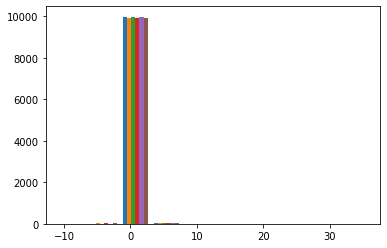

[0.3380661  0.37220636 0.3013771  0.33751923 0.2701493  0.30739605]


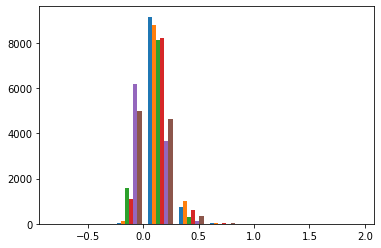

[0.14597684 0.165309   0.07157549 0.09490915 0.01798289 0.04306805]
Train on 10000 samples
Epoch 1/15
10000/10000 [==============================] - 3s 267us/sample - loss: 0.0196
Epoch 2/15
10000/10000 [==============================] - 3s 263us/sample - loss: 0.0195
Epoch 3/15
10000/10000 [==============================] - 3s 267us/sample - loss: 0.0195
Epoch 4/15
10000/10000 [==============================] - 3s 268us/sample - loss: 0.0194
Epoch 5/15
10000/10000 [==============================] - 3s 291us/sample - loss: 0.0193
Epoch 6/15
10000/10000 [==============================] - 3s 275us/sample - loss: 0.0192
Epoch 7/15
10000/10000 [==============================] - 3s 274us/sample - loss: 0.0191
Epoch 8/15
10000/10000 [==============================] - 3s 261us/sample - loss: 0.0190
Epoch 9/15
10000/10000 [==============================] - 3s 261us/sample - loss: 0.0189
Epoch 10/15
10000/10000 [==============================] - 3s 262us/sample - loss: 0.0188
Epoch 11/15
10000/

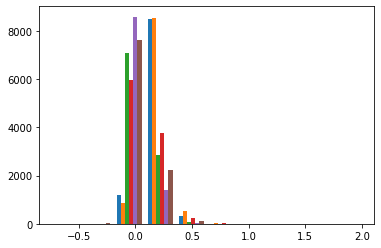

[0.14599405 0.16521174 0.0715927  0.09481161 0.01800018 0.04297056]


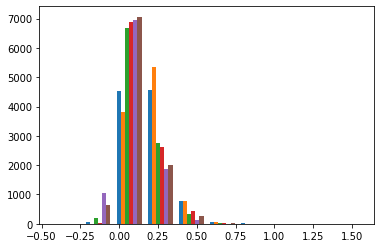

[0.1953973  0.20900674 0.1312335  0.14484183 0.07771978 0.08961852]
Train on 10000 samples
Epoch 1/15
10000/10000 [==============================] - 3s 262us/sample - loss: 0.0147
Epoch 2/15
10000/10000 [==============================] - 3s 265us/sample - loss: 0.0144
Epoch 3/15
10000/10000 [==============================] - 3s 254us/sample - loss: 0.0141
Epoch 4/15
10000/10000 [==============================] - 3s 254us/sample - loss: 0.0138
Epoch 5/15
10000/10000 [==============================] - 3s 254us/sample - loss: 0.0136
Epoch 6/15
10000/10000 [==============================] - 3s 254us/sample - loss: 0.0133
Epoch 7/15
10000/10000 [==============================] - 3s 257us/sample - loss: 0.0131
Epoch 8/15
10000/10000 [==============================] - 3s 256us/sample - loss: 0.0129
Epoch 9/15
10000/10000 [==============================] - 3s 264us/sample - loss: 0.0127
Epoch 10/15
10000/10000 [==============================] - 3s 259us/sample - loss: 0.0125
Epoch 11/15
10000/

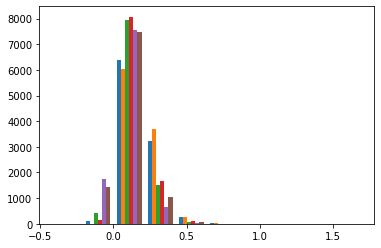

[0.19520554 0.20874812 0.13104123 0.14458309 0.07752795 0.08935998]


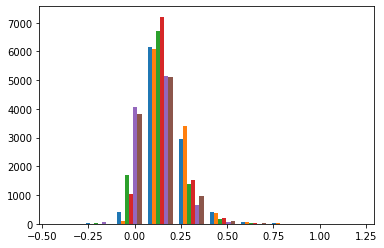

[0.1997764  0.213974   0.13666835 0.15083876 0.08373914 0.09629694]


In [11]:
localvol_trainhedge.compile(optimizer='Adam' , #optimizer='adam', 
              loss=tf.keras.losses.MeanSquaredError() ) #loss='mean_squared_error')
localvol_trainlocvol.compile(optimizer='Adam' , #optimizer='adam', 
              loss=tf.keras.losses.MeanSquaredError() ) #loss='mean_squared_error')

for i in range(3):
    localvol_trainhedge.fit(x=xtrain,y=ytrain, epochs=15,verbose=True, batch_size=10**2) # batch_size > 1 improves result
    x = localvol_trainhedge.get_weights()
    localvol_trainlocvol.set_weights(x)
    localvol_trainlocvol.fit(x=xtrain,y=ytrain, epochs=5,verbose=True, batch_size=10**2)
    prediction_hedge = localvol_trainhedge.predict(xtrain)[:,:]
    prediction_locvol = localvol_trainlocvol.predict(xtrain)[:,:]
    plt.hist(prediction_hedge)
    plt.show()
    print(np.mean(prediction_hedge, axis=0))
    plt.hist(prediction_locvol)
    plt.show()
    print(np.mean(prediction_locvol, axis=0))
    y = localvol_trainlocvol.get_weights()
    localvol_trainhedge.set_weights(y)

Hedging helps to reduce variance tremendously, whence we are able to go for a classical means square calibration approach, which is implemented below with a custom loss function.

In [12]:
def custom_loss(y_true,y_pred):
    return K.mean((K.mean(y_pred,axis=0)-K.mean(y_true,axis=0))**2)

localvol_trainlocvol.compile(optimizer='Adam', 
              loss=custom_loss)

In [13]:
for i in range(10):
    localvol_trainlocvol.fit(x=xtrain,y=ytrain, epochs=5, verbose=True,batch_size=10**2) # for larger batch-size the kernel dies, originally this was maxi-batch
    pred = localvol_trainlocvol.predict(xtrain)[:,:]
#     plt.hist(pred)
#     plt.show()
    print('Variance:', np.var(pred,axis=0))
    print('Mean:', np.mean(pred,axis=0))
    
#    localvol_trainlocvol2.fit(x=xtrain,y=ytrain2, epochs=5, verbose=True,batch_size=5*10**1)
#    pred2 = localvol_trainlocvol2.predict(xtrain)[:,:]
#    plt.hist(pred2)
#    plt.show()
#    print(np.mean(pred2,axis=0))

Train on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 63s 6ms/sample - loss: 7.5643e-04
Epoch 2/5
10000/10000 [==============================] - 9s 920us/sample - loss: 6.5480e-04
Epoch 3/5
10000/10000 [==============================] - 9s 935us/sample - loss: 6.1537e-04
Epoch 4/5
10000/10000 [==============================] - 9s 941us/sample - loss: 6.3487e-04
Epoch 5/5
10000/10000 [==============================] - 10s 973us/sample - loss: 6.3730e-04
Variance: [0.01546849 0.03336444 0.01402385 0.03214821 0.0126139  0.03203081]
Mean: [0.2201354  0.25223637 0.1616897  0.19706066 0.11208844 0.14845836]
Train on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 9s 940us/sample - loss: 6.2111e-04
Epoch 2/5
10000/10000 [==============================] - 9s 928us/sample - loss: 5.5868e-04
Epoch 3/5
10000/10000 [==============================] - 9s 940us/sample - loss: 5.5903e-04
Epoch 4/5
10000/10000 [==============================] - 9s 921us/

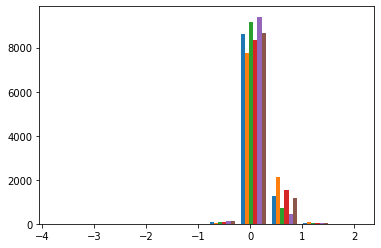

Variance: [0.02567247 0.03769203 0.02416423 0.03702737 0.02242778 0.03768696]
Calibrated values: [0.21281685 0.2513515  0.1588584  0.20076679 0.11563672 0.15805465]
Ground truth: [0.20042534, 0.23559685, 0.16312157, 0.20771958, 0.13154241, 0.18236567]


In [14]:
Ltest = 10**5


sv_proc = sv_process(nu_res, rho_res, 1.0, Ltest)


xtest =([np.ones(Ltrain)] + [np.zeros(Ltrain) for key in keylist] +
         [np.asarray([sv_proc[0][k][t] for k in range(Ltrain)]) for t in range(N)] +
         [np.asarray([sv_proc[1][k][t] for k in range(Ltrain)]) for t in range(N)])


# xtest =([np.ones(Ltest)] + [np.zeros(Ltest) for key in keylist]+
#          [np.random.normal(0,1,Ltest) for i in range(N)]+
#          [np.ones(Ltest) for i in range(N)])


pred = localvol_trainlocvol.predict(xtest)[:,:]
#pred2 = localvol_trainlocvol2.predict(xtest)[:,:]

plt.hist(pred)
plt.show()
print('Variance:', np.var(pred,axis=0))
print('Calibrated values:', np.mean(pred,axis=0))
print('Ground truth:', [P[key] for key in keylist])
#plt.hist(pred2)
#plt.show()
#print('Calibrated values2:', np.mean(pred2,axis=0))
#print('Ground truth2:', [4.0 for key in keylist])

In [ ]:
P

Comparing with SV-calibration:

In [6]:
print(nu_res, rho_res)
test = sp_test_sv([nu_res, rho_res],1000000)
print(test)
print(P_data)

# print(nu_res2, rho_res2)
# test2 = sp_test_sv2([nu_res2, rho_res2],10000)
# print(test2)
# print([P[key] for key in P.keys()])

0.9244964101097016 -0.43701377885829595
[[0.21821676967403977, 0.1807490860212327, 0.14908723023767065], [0.2262041840750446, 0.19593662374964207, 0.17001267642634763]]
[[[0.9, 0.20042534], [1.0, 0.16312157], [1.1, 0.13154241]], [[0.9, 0.23559685], [1.0, 0.20771958], [1.1, 0.18236567]]]


The following code samples correlated Wiener processes with correlation $\rho$. This is needed for including stochastic SABR volatility later.

In [ ]:
n = 1000000; dt = 0.01; rho = -0.3
dW1 = np.random.normal(0, np.sqrt(dt), n)
dW2 = rho * dW1 + np.sqrt(1 - rho **2) * np.random.normal(0, np.sqrt(dt), n)
W1 = np.cumsum(dW1)
W2 = np.cumsum(dW2)
plt.plot(W1)
plt.plot(W2)
plt.show()

... not so bad.

In [ ]:
#maturities = [0.1, 0.25, 0.5, 1.0]
#strikes = [0.8, 0.9, 1.0, 1.1, 1.2]
#for T in maturities:
#    for K in strikes:
#         P[(K,T)] = 1.0
#Lgen = 10**6
#keylist = P.keys()
#xgen =([np.ones(Lgen)] + [np.zeros(Lgen) for key in keylist]+
#       [np.random.normal(0,1,Lgen) for i in range(N)]+
#       [np.ones(Lgen) for i in range(N)])
#
#ygen=np.mean(localvol_trainlocvol.predict(xgen)[:,:],axis=0)
#for l in range(len(P.keys())):
#    key = keylist[l]
#    P[key] = ygen[1,l]